In [ ]:
import numpy as np 
import pandas as pd 
import os 
import gudhi as gd


import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import networkx as nx

from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from hyppo.independence import Hsic
from matplotlib import cm
from dtw import *



# Path to your folder
folder_path = 'data/DpShipData'

# Dictionary to store DataFrames
dataframes = {}

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Extract name before the first underscore
        df_name = filename.split('_')[0]
        file_path = os.path.join(folder_path, filename)
        dataframes[df_name] = pd.read_csv(file_path)

##################################################################

file_paths = [
    "Ship_20250718_123324_891097.csv",
    "ThrustAllocation_20250718_123324_891788.csv",
    "ReferenceGenerator_20250718_123324_891651.csv",
    "DPController_20250718_123324_890377.csv",
    "Observer_20250718_123324_890910.csv"
]


# Read and rename columns to avoid collisions, except for the 'time' column
dfs = []
for path in file_paths:
    print("Loading: "+ str(folder_path+"/"+path))
    df = pd.read_csv(folder_path+"/"+path)
    df=df.drop(columns=["StepCount"])
    dfs.append(df)

# Merge all dataframes on the 'time' column using outer join
master_df = dfs[0]
for df in dfs[1:]:
    master_df = pd.merge(master_df, df, on="Time", how="outer")
master_df=master_df.iloc[:5968,:]





Loading: data/DpShipData/Ship_20250718_123324_891097.csv
Loading: data/DpShipData/ThrustAllocation_20250718_123324_891788.csv
Loading: data/DpShipData/ReferenceGenerator_20250718_123324_891651.csv
Loading: data/DpShipData/DPController_20250718_123324_890377.csv
Loading: data/DpShipData/Observer_20250718_123324_890910.csv


In [60]:
def distance_correlation(x, y):
    x = x[:, None]
    y = y[:, None]
    a = np.abs(x - x.T)
    b = np.abs(y - y.T)
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    dcov = np.sqrt((A * B).mean())
    dvar_x = np.sqrt((A * A).mean())
    dvar_y = np.sqrt((B * B).mean())
    return dcov / np.sqrt(dvar_x * dvar_y) if dvar_x > 0 and dvar_y > 0 else 0


In [61]:
scaler = StandardScaler()
master_df=master_df.drop(columns=['Time','y_hat[3]'])
df_norm=pd.DataFrame(scaler.fit_transform(master_df), columns=master_df.columns)

In [5]:
results = []
for i in range(len(master_df.columns)):
    for j in range(i + 1, len(master_df.columns)):
        x = df_norm.iloc[:, i].values
        y = df_norm.iloc[:, j].values

        pearson_val, _ = pearsonr(x, y)
        dcor_val = distance_correlation(x, y)
        try:
            dtw_val = dtw(x,y,distance_only=True)
        except ValueError:
            dtw_val= float("nan")
        try:
            hsic_val = Hsic().statistic(np.reshape(x,(-1,1)),np.reshape(y,(-1,1)))
        except ValueError:
            hsic_val=float("nan")

        results.append({
            "Var1": master_df.columns[i],
            "Var2": master_df.columns[j],
            "Pearson": pearson_val,
            "Distance_Correlation": dcor_val,
            "DTW" : dtw_val,
            "HSIC": hsic_val
        })

results_df = pd.DataFrame(results)
#Note the dtw might need to be normalized here before compared to anything


In [6]:
results_df["DTWDistance"] = 1
dtw_distance=[]

for i in range(len(results_df)):
    try:
        #print(results_df["DTW"][i].normalizedDistance)
        dtw_distance.append(results_df["DTW"][i].normalizedDistance)
    except AttributeError:
        #print("index at failure is:" + str(i))
        dtw_distance.append(0)
#dtw_distance
results_df["DTWDistance"]=dtw_distance

In [58]:
import pickle
#results_df.to_pickle('pickled_dfs/RipsComp.pkl')
results_df=pd.read_pickle('pickled_dfs/RipsComp.pkl')

Text(0, 0.5, ' Y position')

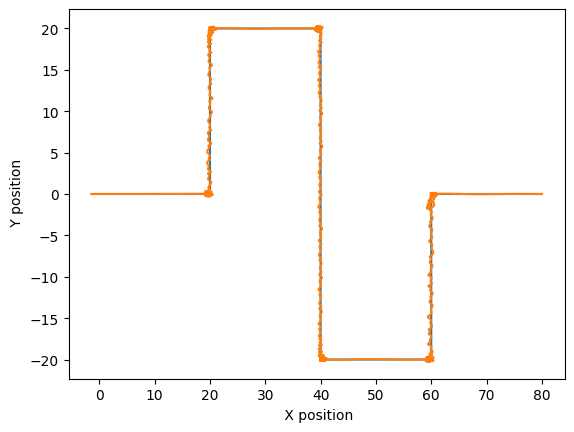

In [71]:
master_df.columns
plt.plot(master_df["x_wp"],master_df["y_wp"])
plt.xlabel(" X waypoint")
plt.ylabel(" Y waypoint")

plt.plot(master_df["q[1]"],master_df["q[2]"])
plt.xlabel(" X position")
plt.ylabel(" Y position")


Building Vietoris–Rips complex from Pearson correlation...
Number of simplices: 741
Building Vietoris–Rips complex from Distance correlation...
Number of simplices: 1692
Building Vietoris–Rips complex from DTW correlation...
Number of simplices: 71
Building Vietoris–Rips complex from HSIC correlation...
Number of simplices: 766


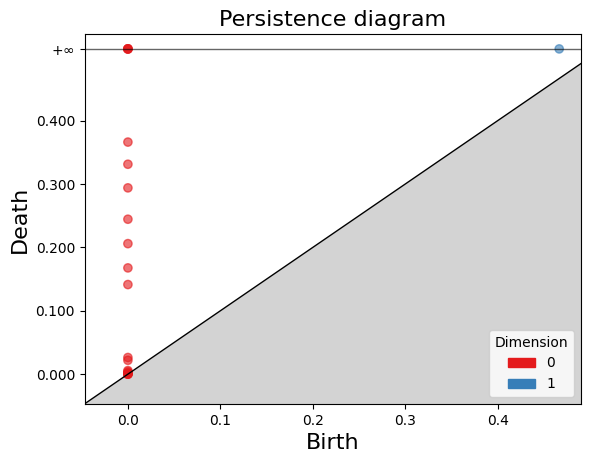

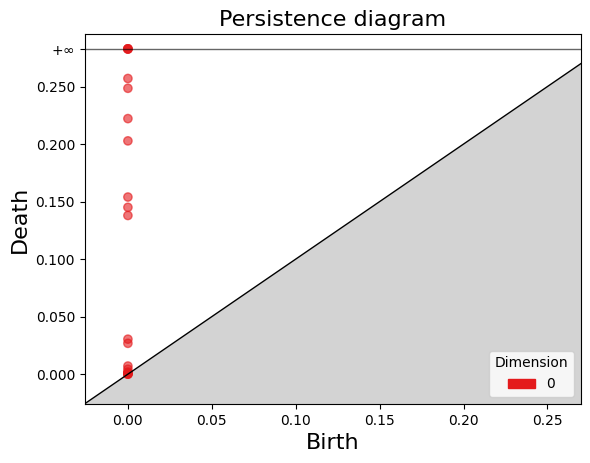

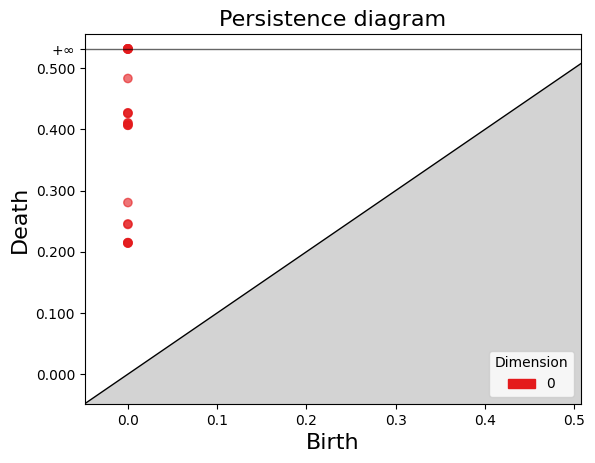

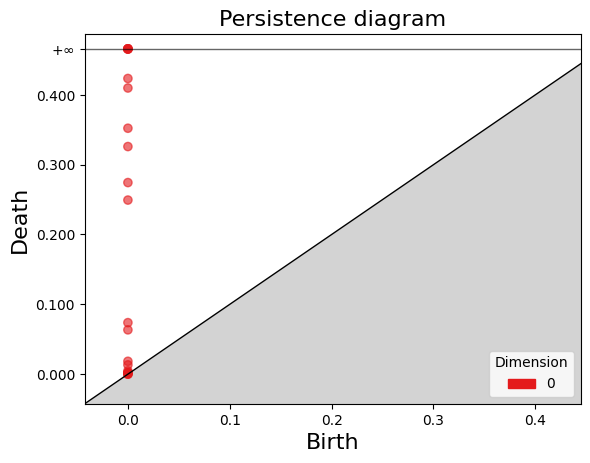

In [22]:
# Step 1: Get list of unique variables
variables = sorted(set(results_df['Var1']).union(set(results_df['Var2'])))
var_index = {var: i for i, var in enumerate(variables)}
n = len(variables)

# Step 2: Create distance matrices
pearson_dist = np.ones((n, n))
dcor_dist = np.ones((n, n))
dtw_dist = np.ones((n, n))
hsic_dist = np.ones((n, n))

for _, row in results_df.iterrows():
    i, j = var_index[row['Var1']], var_index[row['Var2']]
    pearson_dist[i, j] = pearson_dist[j, i] = 1 - abs(row['Pearson'])
    dcor_dist[i, j] = dcor_dist[j, i] = 1 - row['Distance_Correlation']
    dtw_dist[i, j] = dtw_dist[j, i] = 1 - row['DTWDistance']
    hsic_dist[i, j] = hsic_dist[j, i] = 1 - row['HSIC']

# Step 3: Build Vietoris–Rips complex from distance matrix
def build_rips_complex(dist_matrix, max_edge_length=0.6, max_dim=4):
    rips = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_edge_length)
    simplex_tree = rips.create_simplex_tree(max_dimension=max_dim)
    print(f"Number of simplices: {simplex_tree.num_simplices()}")
    diag = simplex_tree.persistence()
    gd.plot_persistence_diagram(diag)
    return simplex_tree, diag

# Pearson-based complex
print("Building Vietoris–Rips complex from Pearson correlation...")
simplex_pearson, diag_pearson = build_rips_complex(pearson_dist)

# Distance correlation-based complex
print("Building Vietoris–Rips complex from Distance correlation...")
simplex_dcor, diag_dcor = build_rips_complex(dcor_dist)

# DTW-based complex
print("Building Vietoris–Rips complex from DTW correlation...")
simplex_dtw, diag_dtw = build_rips_complex(dtw_dist)

# HSIC correlation-based complex
print("Building Vietoris–Rips complex from HSIC correlation...")
simplex_hsic, diag_hsic = build_rips_complex(hsic_dist)


In [44]:

def describe_persistence_features(stree, variables):
    diagram = stree.persistence()
    pairs = stree.persistence_pairs()

    def name_simplex(simplex):
        if not simplex:
            return "∞ (persists forever)"
        named_nodes = [variables[i] for i in simplex]
        if len(simplex) == 1:
            return f"Node '{named_nodes[0]}'"
        elif len(simplex) == 2:
            return f"Edge between '{named_nodes[0]}' and '{named_nodes[1]}'"
        elif len(simplex) == 3:
            nodes_str = ", ".join(f"'{n}'" for n in named_nodes)
            return f"Triangle formed by {nodes_str}"
        else:
            nodes_str = ", ".join(f"'{n}'" for n in named_nodes)
            return f"{len(simplex)-1}D simplex with nodes {nodes_str}"

    for i, ((birth_time, death_time), (birth_simplex, death_simplex)) in enumerate(zip(diagram, pairs)):
        death_str = f"{death_time}" if death_simplex else "∞"
        print(f"Feature {i}:")
        print(f"  Born at {birth_time} from {name_simplex(birth_simplex)}")
        print(f"  Dies at {death_str} from {name_simplex(death_simplex)}")
        print()



In [42]:
describe_persistence_features(simplex_hsic,master_df.columns)

Feature 0:
  Born at 0 from Node 'Controly'
  Dies at (0.0, inf) from Edge between 'Controly' and 'y_wp'

Feature 1:
  Born at 0 from Node 'y_hat[1]'
  Dies at (0.0, inf) from Edge between 'y_hat[1]' and 'y_ref'

Feature 2:
  Born at 0 from Node 'y_wp'
  Dies at (0.0, inf) from Edge between 'Controly' and 'psi_ref'

Feature 3:
  Born at 0 from Node 'Fxg'
  Dies at (0.0, inf) from Edge between 'Fxg' and 'q[1]'

Feature 4:
  Born at 0 from Node 'F3c'
  Dies at (0.0, inf) from Edge between 'F3c' and 'q[3]'

Feature 5:
  Born at 0 from Node 'psi_wp'
  Dies at (0.0, 0.4234133433457281) from Edge between 'psi_wp' and 'F3c'

Feature 6:
  Born at 0 from Node 'q[3]'
  Dies at (0.0, 0.40976124122501134) from Edge between 'psi_wp' and 'x_wp'

Feature 7:
  Born at 0 from Node 'x_wp'
  Dies at (0.0, 0.3521597848001793) from Edge between 'psi_wp' and 'F1c'

Feature 8:
  Born at 0 from Node 'F1c'
  Dies at (0.0, 0.3259205430426012) from Edge between 'F1c' and 'q[1]'

Feature 9:
  Born at 0 from Node 

In [45]:
from gudhi.representations.vector_methods import PersistenceImage
import gudhi.representations
a=PersistenceImage(diag_hsic)
#PI=gd.representations.PersistenceImage(bandwidth=1e-4, weight=lambda x: x[1]**2, \
                                         #im_range=[0,.004,0,.004], resolution=[100,100])
#pi=PI.fit_transform([simplex_hsic.persistence_intervals_in_dimension(1)])
#plt.imshow(np.flip(np.reshape(pi[0], [100,100]), 0))
#plt.title("Persistence Image")

IndentationError: unexpected indent (2362471558.py, line 5)

In [46]:

def visualize_rips_1_skeleton(simplex_tree, variable_names, title=""):
    """
    Visualize the 1-skeleton (nodes and edges) of a Rips complex using variable names as labels.

    Parameters:
    - simplex_tree: GUDHI SimplexTree object
    - variable_names: list of variable names in the same order as used to build the distance matrix
    """
    G = nx.Graph()

    for simplex, _ in simplex_tree.get_simplices():
        if len(simplex) == 1:
            node = simplex[0]
            G.add_node(variable_names[node])
        elif len(simplex) == 2:
            u, v = simplex
            G.add_edge(variable_names[u], variable_names[v])

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42, k=1.5)  # Increase k for more spacing
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2.5)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    plt.title("1-Skeleton of Vietoris–Rips Complex (Variable Labels)" + title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()



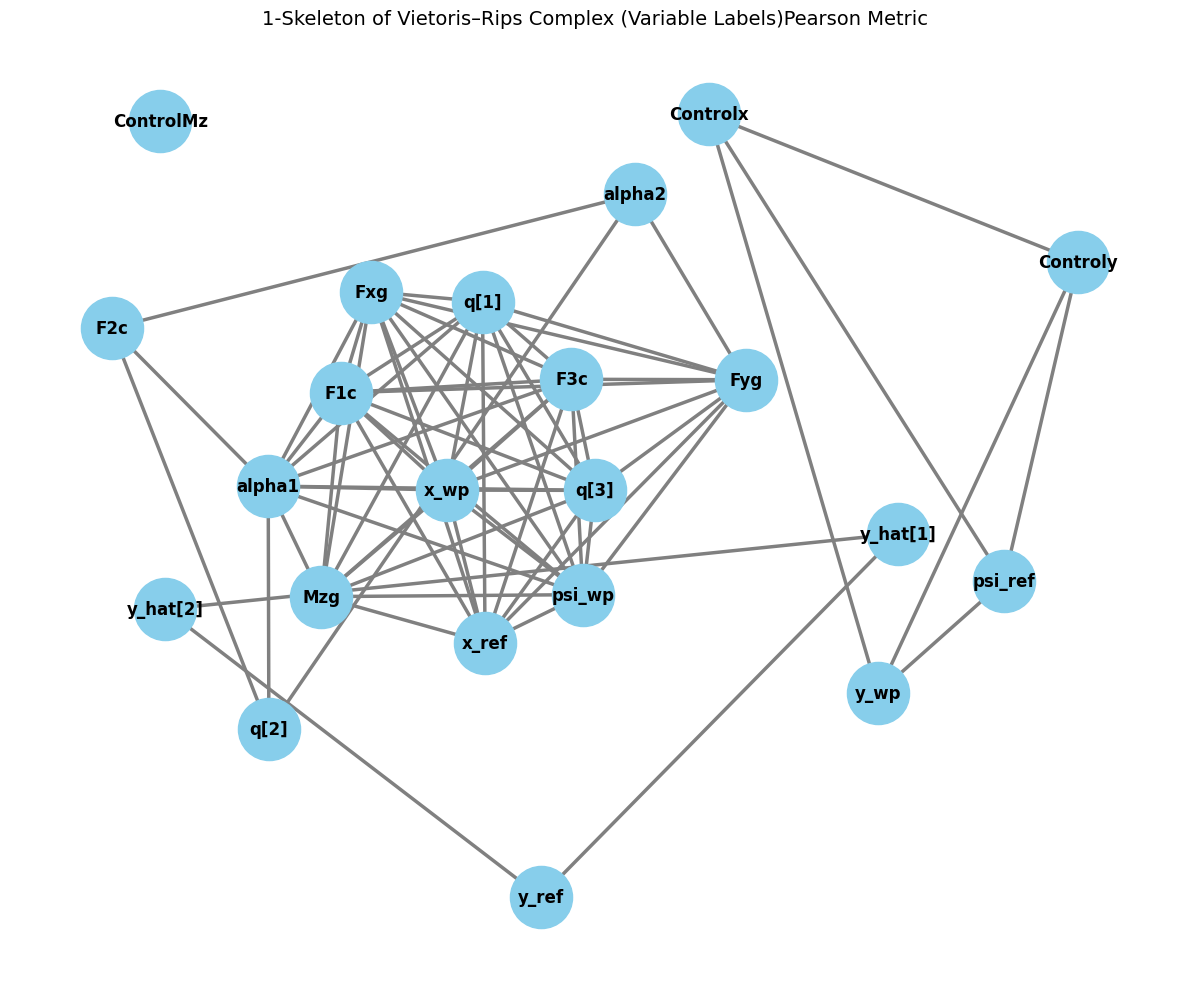

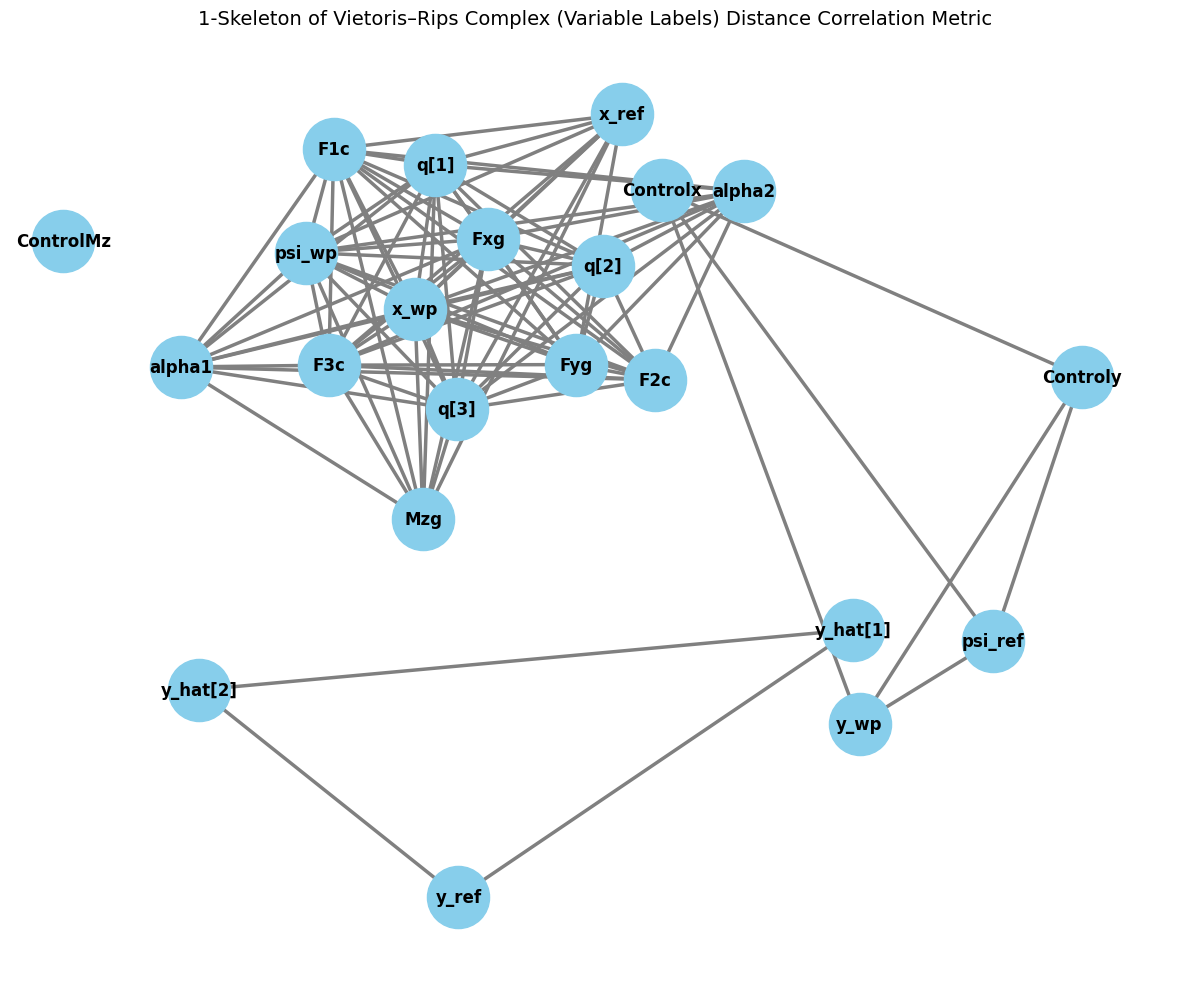

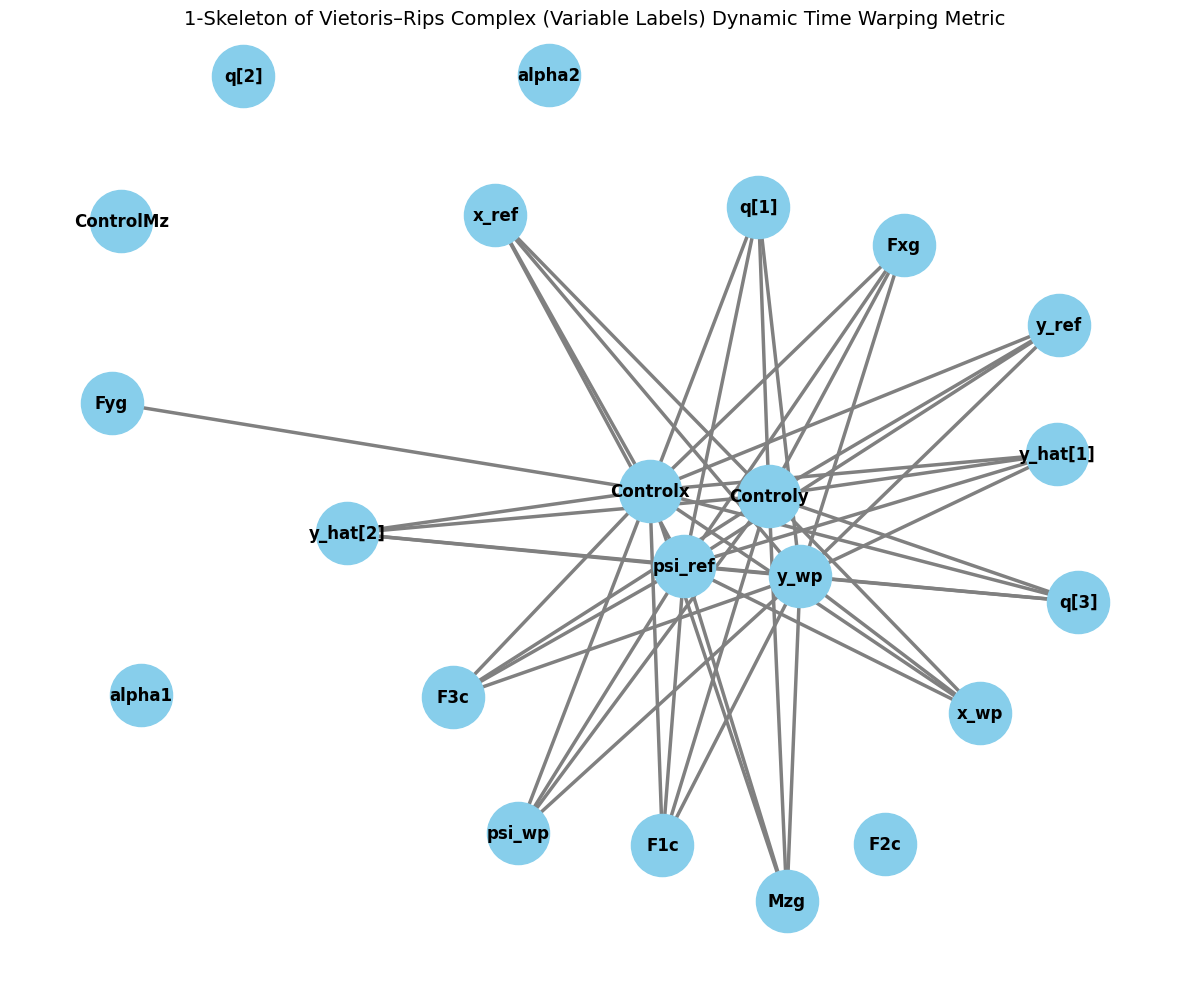

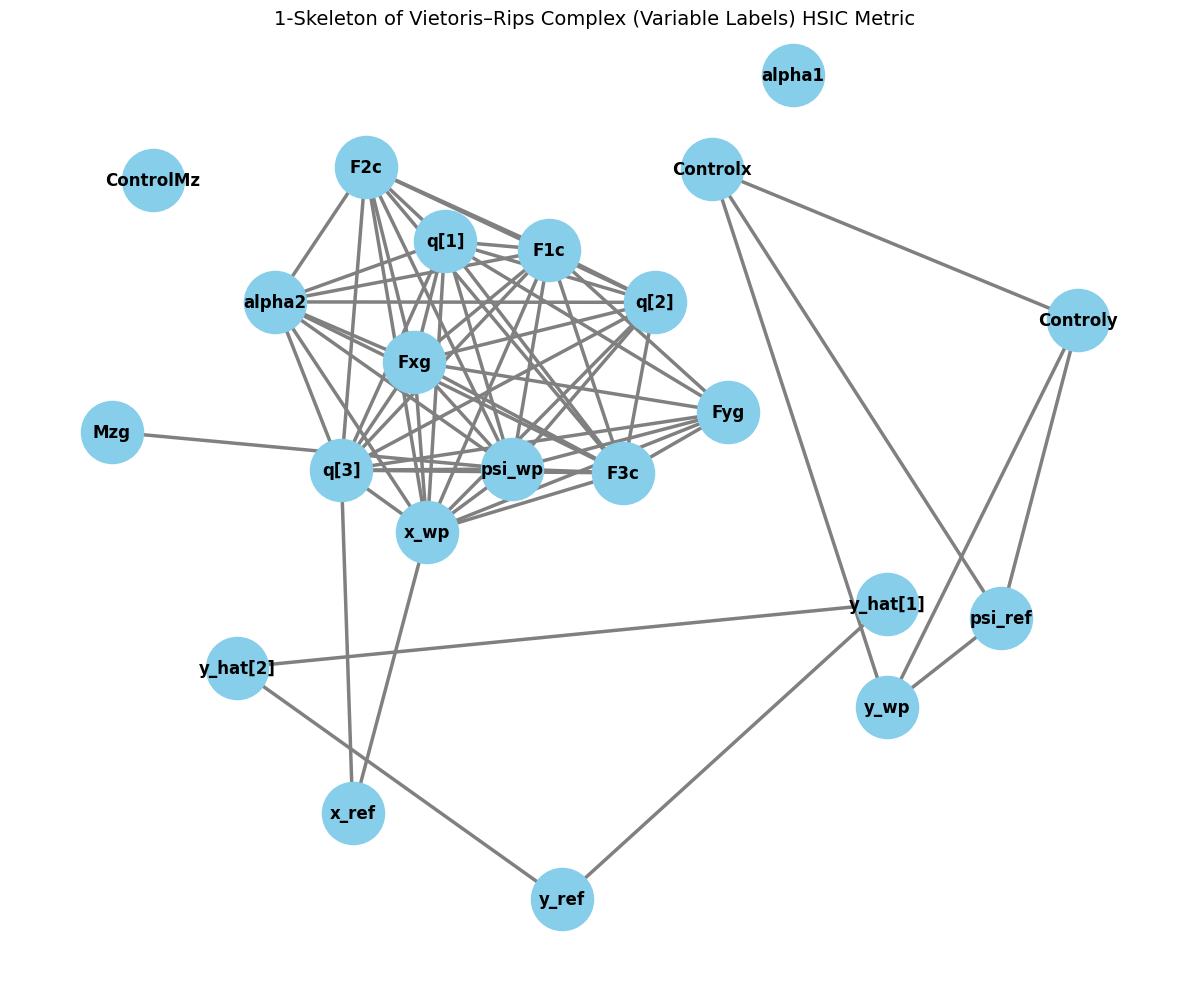

In [47]:
visualize_rips_1_skeleton(simplex_pearson,master_df.columns, title="Pearson Metric")
visualize_rips_1_skeleton(simplex_dcor,master_df.columns, title=" Distance Correlation Metric")
visualize_rips_1_skeleton(simplex_dtw,master_df.columns, title=" Dynamic Time Warping Metric")
visualize_rips_1_skeleton(simplex_hsic,master_df.columns, title=" HSIC Metric")

In [48]:

def build_correlation_matrix(df, value_column):
    matrix = df.pivot(index='Var1', columns='Var2', values=value_column)
    matrix_full = matrix.copy()

    # Fill in the lower triangle to make it symmetric
    for i in matrix.index:
        for j in matrix.columns:
            if pd.isna(matrix.at[i, j]):
                if j in matrix.index and i in matrix.columns:
                    matrix_full.at[i, j] = matrix.at[j, i]

    # Fill diagonal with 1.0
    for var in set(df['Var1']).union(set(df['Var2'])):
        matrix_full.at[var, var] = 1.0

    # Ensure symmetry
    matrix_full = matrix_full.combine_first(matrix_full.T)

    return matrix_full


In [49]:

pearson_matrix = build_correlation_matrix(results_df, 'Pearson')
distance_matrix = build_correlation_matrix(results_df, 'Distance_Correlation')
dtw_matrix=build_correlation_matrix(results_df, "DTWDistance")
hsic_matrix=build_correlation_matrix(results_df,"HSIC")
hsic_matrix=hsic_matrix.replace(np.nan,0) #is this the correct way to do it?


In [50]:

def visualize_rips_1_skeleton_3d(simplex_tree, variable_names, correlation_matrix, max_clusters=4):
    """
    Visualize the 1-skeleton of a Vietoris–Rips complex in 3D with enhanced aesthetics.

    Parameters:
    - simplex_tree: GUDHI SimplexTree object
    - variable_names: list of variable names in order
    - correlation_matrix: pandas DataFrame with absolute correlation values
    - max_clusters: number of clusters for coloring nodes
    """
    # Build graph from 1-skeleton
    G = nx.Graph()
    for simplex, _ in simplex_tree.get_simplices():
        if len(simplex) == 1:
            G.add_node(simplex[0])
        elif len(simplex) == 2:
            u, v = simplex
            u_label = variable_names[u]
            v_label = variable_names[v]
            weight = correlation_matrix.loc[u_label, v_label]
            G.add_edge(u, v, weight=weight)

    # Compute 3D layout with increased spacing
    pos_3d = nx.spring_layout(G, dim=3, seed=42, k=2.5)

    # Extract node positions
    node_xyz = np.array([pos_3d[v] for v in G.nodes()])
    node_labels = [variable_names[v] for v in G.nodes()]

    # Cluster nodes based on position
    clustering = AgglomerativeClustering(n_clusters=max_clusters)
    cluster_labels = clustering.fit_predict(node_xyz)

    # Plotting
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Draw edges with color and thickness based on weight
    edges = G.edges(data=True)
    weights = [d['weight'] for (_, _, d) in edges]
    norm = plt.Normalize(min(weights), max(weights))
    cmap = cm.viridis

    for u, v, d in edges:
        x = [pos_3d[u][0], pos_3d[v][0]]
        y = [pos_3d[u][1], pos_3d[v][1]]
        z = [pos_3d[u][2], pos_3d[v][2]]
        ax.plot(x, y, z, color=cmap(norm(d['weight'])), linewidth=2.5)

    # Draw nodes
    for i, (x, y, z) in enumerate(node_xyz):
        ax.scatter(x, y, z, s=800, c=cm.tab10(cluster_labels[i] % 10), edgecolors='k')
        ax.text(x, y, z, node_labels[i], fontsize=10, ha='center', va='center', color='black', zorder=10)

    # Add colorbar for edge weights
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Correlation Strength', fontsize=12)

    # Show 3D axes
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Vietoris–Rips Complex (1-Skeleton)", fontsize=14)
    plt.tight_layout()
    plt.show()



/tmp/ipykernel_236585/2070871827.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, s=800, c=cm.tab10(cluster_labels[i] % 10), edgecolors='k')


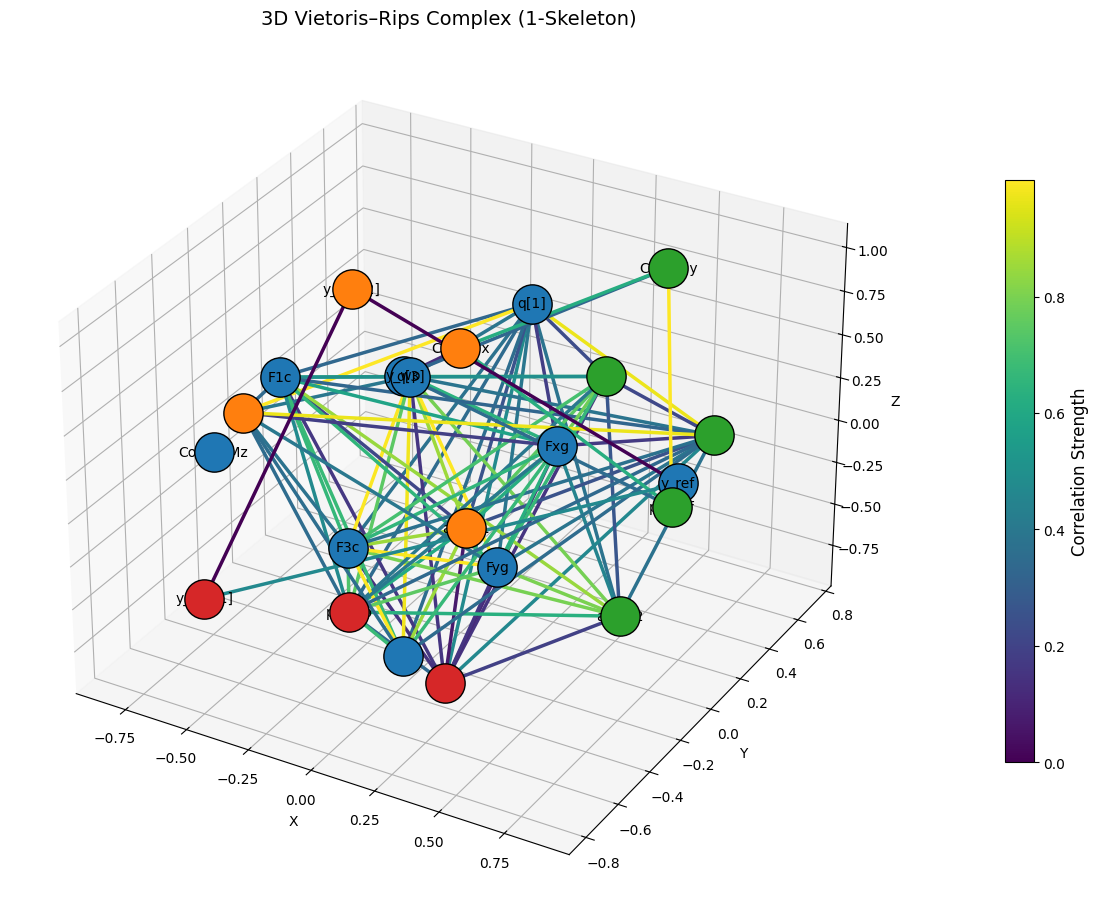

/tmp/ipykernel_236585/2070871827.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, s=800, c=cm.tab10(cluster_labels[i] % 10), edgecolors='k')


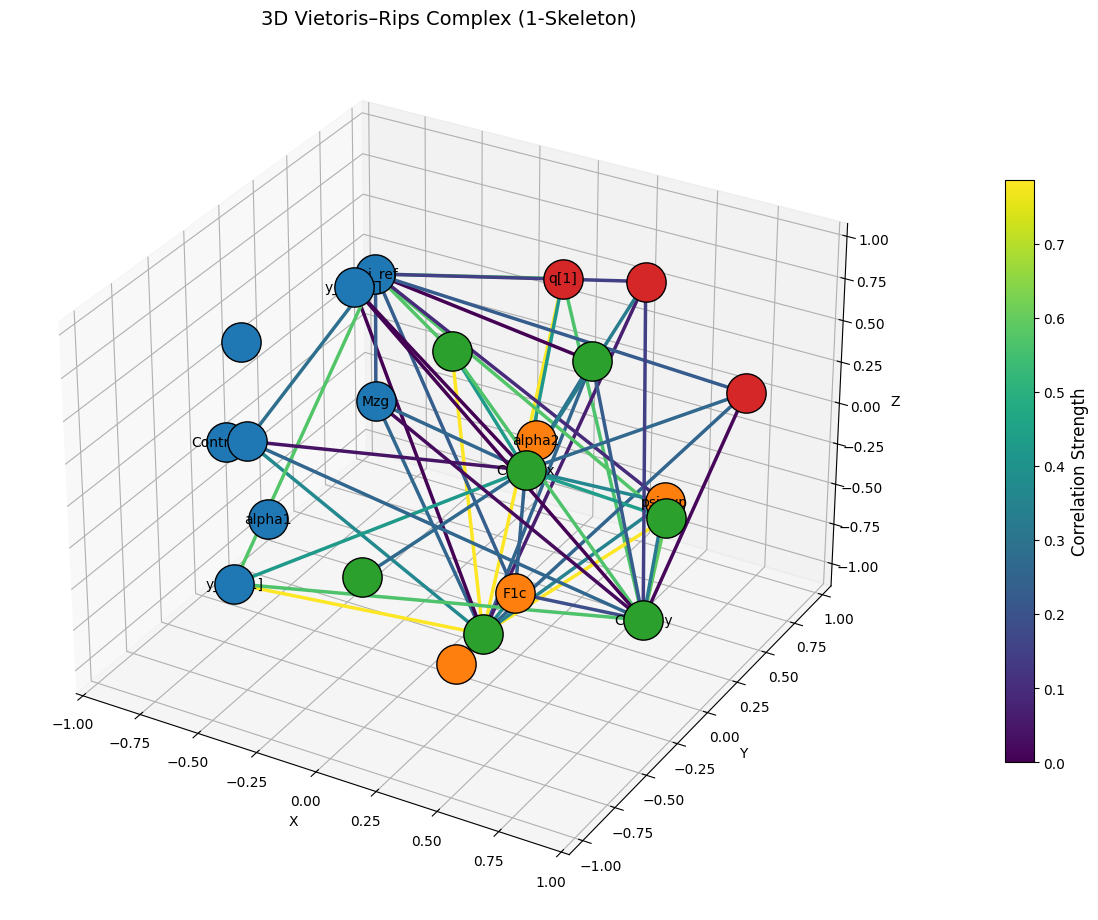

/tmp/ipykernel_236585/2070871827.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, s=800, c=cm.tab10(cluster_labels[i] % 10), edgecolors='k')


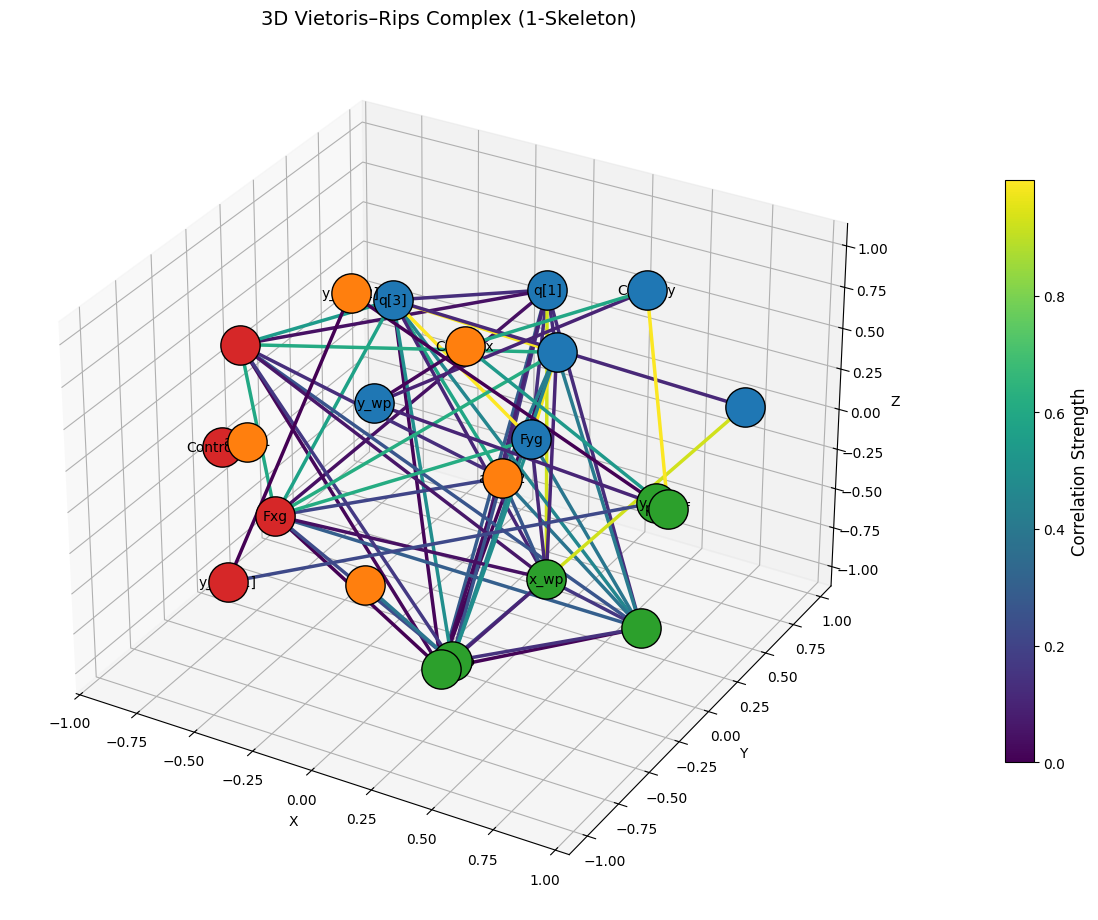

In [33]:

visualize_rips_1_skeleton_3d(simplex_dcor, master_df.columns.tolist(), distance_matrix)
visualize_rips_1_skeleton_3d(simplex_dtw, master_df.columns.tolist(), dtw_matrix)
visualize_rips_1_skeleton_3d(simplex_hsic, master_df.columns.tolist(), hsic_matrix)


In [51]:

from mpl_toolkits.mplot3d.art3d import Poly3DCollection


from sklearn.decomposition import PCA

def plot_simplicial_complex(simplex_tree, labels, correlation_df):
    """
    Visualize a simplicial complex using the first three principal components
    of a correlation matrix (n x n pandas DataFrame).

    Parameters:
    - simplex_tree: gudhi.SimplexTree object
    - labels: list of node labels
    - correlation_df: pandas DataFrame (n x n) representing the correlation matrix
    """
    # Perform PCA to reduce to 3D coordinates
    pca = PCA(n_components=3)
    coords = pca.fit_transform(correlation_df)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot vertices
    for i, coord in enumerate(coords):
        ax.scatter(*coord, color='black')
        ax.text(*coord, labels[i], fontsize=9)

    # Plot edges and faces
    for simplex in simplex_tree.get_simplices():
        vertices, _ = simplex
        pts = coords[vertices]
        if len(vertices) == 2:
            ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color='blue')
        elif len(vertices) == 3:
            tri = Poly3DCollection([pts], alpha=0.5, facecolor='orange')
            ax.add_collection3d(tri)
        elif len(vertices) == 4:
            poly = Poly3DCollection([pts], alpha=0.3, facecolor='green')
            ax.add_collection3d(poly)

    ax.set_title("Simplicial Complex Visualization")
    plt.show()


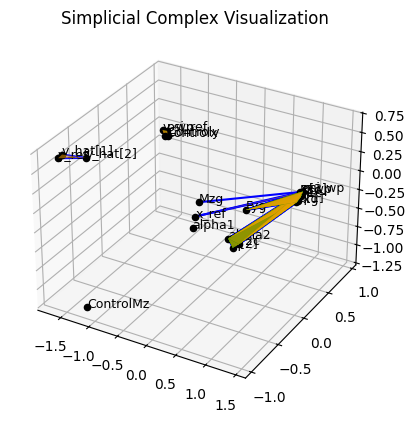

In [53]:
plot_simplicial_complex(simplex_hsic,master_df.columns.tolist(), hsic_matrix)

In [54]:
print(simplex_dcor.num_simplices())
print(simplex_pearson.num_simplices())

print(simplex_dcor.num_vertices())
print(simplex_dcor.betti_numbers())
print(simplex_hsic.betti_numbers())
print(simplex_dtw.betti_numbers())

1692
741
22
[4, 0, 0, 0]
[5, 0, 0, 0]
[6]
